# Using Pytorch to recognise fashion artefacts

Process:
- load and visualise the data
- preprocess data
- define model
- train model
- evaluate model

MNIST contains 70,000 images of handwritten digits: 60,000 for training and 10,000 for testing. The images are grayscale, 28x28 pixels, and centered to reduce preprocessing and get started quicker. 

Based on:
https://colab.research.google.com/drive/1nkAZaX5QQhnO3XN3FE27jW3JKk0tcPd_?usp=sharing#scrollTo=JZcQH0Bto_Gy
https://medium.com/@aaysbt/fashion-mnist-data-training-using-pytorch-7f6ad71e96f4
https://nextjournal.com/gkoehler/pytorch-mnist

## Import required libraries

In [1]:
# Run the following commands using terminal (exclude # !) or directly from cell (remove #)
# !pip3 install pytorch
# !pip3 install torchvision

Required libraries:
- torch - main library for tensor computation and training deep neural networks using pytorch
- The torchvision - consist of popular datasets, model architectures, and common image transformations for computer vision; used to fetch fashion-MNIST dataset
- torch.nn - building blocks for graphs
- torch.nn.functional - contains non-linear activation functions like relu, softmin, softmax, logsigmoid, etc.
- torch.optim - implements various optimization algorithms like SGD and Adam.
- matplotlub - library for creating static, animated, and interactive visualizations in Python.

In [2]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt

## Define hyperparameters

In [3]:
# n_pochs defines how many times we'll loop over the complete training dataset
n_epochs = 3

# define batch sizes for training and testing
batch_size_train = 64
batch_size_test = 1000

# learning_rate controls how much to change the model
# in response to the estimated error each time the model weights are updated
learning_rate = 0.01
# momentum might increase the speed of training.

momentum = 0.5

# technical metric to support logging model training's progress
log_interval = 10

# seed required when random sampling used
random_seed = 1

# cudnn is a GPU-accelerated library that provided tuned implementations for 
# forward and backward convolution, pooling, normalization, and activation layers

torch.backends.cudnn.enabled = False

# Set the seed for generating random number
torch.manual_seed(random_seed)

## Import and prepare data
- torch.utils.data.Dataloader is a Pytorch's data loader facility to be used to load MNIST datasets available in torchvision.datasets; batch_size define the how many samples per batch to load, and shuffle parameter set the True to have the data reshuffled at every epoch.
- transforms.Compose creates a series of transformation to prepare the dataset
- transforms.ToTenser convert PIL image(L, LA, P, I, F, RGB, YCbCr, RGBA, CMYK, 1) or numpy.ndarray (H x W x C) in the range [0, 255] to a torch.FloatTensor of shape (C x H x W) in the range [0.0, 1.0].
- transform.Normalize Normalize a tensor image with mean and standard deviation.


In [4]:
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('~/.pytorch/F_MNIST_data', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('~/.pytorch/F_MNIST_data', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=True)

## Analyse the data

### Validate numbers
We should have 1000 examples of 28x28 pixels in grayscale in test set.

In [5]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)
example_data.shape

torch.Size([1000, 1, 28, 28])

### Validate pictures against labels

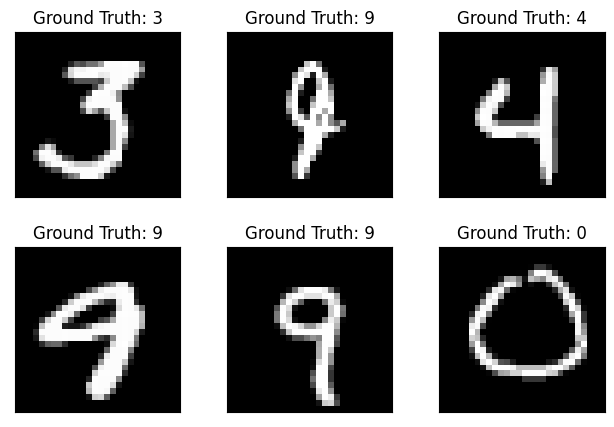

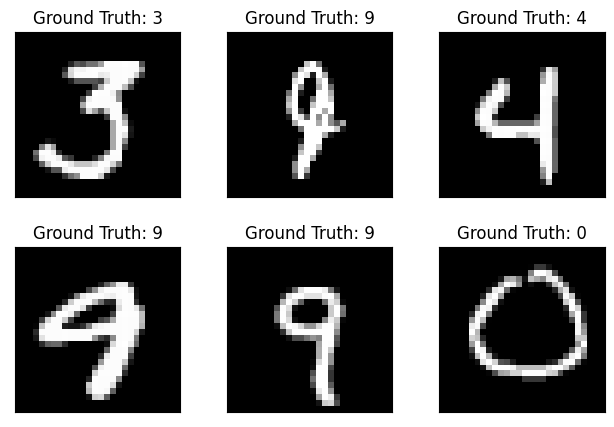

In [6]:
# define plot for a figure
fig = plt.figure()
# display 6 pictures next to each other
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  # do not display scale
  plt.xticks([])
  plt.yticks([])
fig

# Build the network

### Define layers
- two 2-D convolutional layers
- two fully-connected (or linear) layers
- ReLUs as activation function
- two dropout layers for regulization

The forward() pass defines the way we compute our output using the given layers and functions.

In [7]:
class Net(nn.Module):
    # define network
    def __init__(self):
        super(Net, self).__init__()
        # define convolutional layers
        # syntax nn.Conv2d(input_channels, output_channels, kernel_size)
        # First 2D convolutional layer, taking in 1 input channel (image),
        # outputting 10 convolutional features, with a square kernel size of 5
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        # Second 2D convolutional layer, taking in the 10 input layers,
        # outputting 20 convolutional features, with a square kernel size of 5
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        # Dropout is a regularization technique for reducing overfitting in neural networks
        # Designed to ensure that adjacent pixels are either all 0s or all active
        self.conv2_drop = nn.Dropout2d()
        # First fully connected layer
        self.fc1 = nn.Linear(320, 50)
        # Second fully connected layer that outputs our 10 labels
        self.fc2 = nn.Linear(50, 10)

    # specify how data passes through model
    def forward(self, x):
        # pass data through conv1
        # max_pool2d applies a 2D max pooling over an input signal composed of several input planes
        # relu appliesy the rectified linear unit function
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        # view returns a new tensor with the same data as the self tensor but of a different shape
        x = x.view(-1, 320)
        # pass data through first connected layer and apply relu function
        x = F.relu(self.fc1(x))
        # pass data through dropout layer
        x = F.dropout(x, training=self.training)
        # pass data through second connected layer
        x = self.fc2(x)
        # log_softmax applies a softmax followed by a logarithm
        return F.log_softmax(x)

### Initiate network and optimizer

In [8]:
# initalize network
network = Net()
print(network)

# initalize optimizer
optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                      momentum=momentum)

Net(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)


## Train the model

In [9]:
# reset counters
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

In order to train the netowrk we have to loop over our data iterator, feed the inputs to the network, calculate loss and optimize.

In [10]:
def train(epoch):
  network.train() # informs layers about the training process
  for batch_idx, (data, target) in enumerate(train_loader):
    optimizer.zero_grad() # set parameter gradients to zero
    output = network(data) # produce output
    loss = F.nll_loss(output, target) # calculate loss between the output and label using negative log likelihood
    loss.backward() # collect gradients
    optimizer.step() # propagate gradients into network's parameters
    if batch_idx % log_interval == 0: # print statistics in a log
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset),
        100. * batch_idx / len(train_loader), loss.item()))
      # update statistics
      train_losses.append(loss.item())
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
      # save model
      torch.save(network.state_dict(), '../models/model.pth')
      torch.save(optimizer.state_dict(), '../models/optimizer.pth')

Evaluate the model with test data and randomly initalized parameters

In [11]:
def test():
  network.eval() # indicates the model that nothing new is to be learnt
  test_loss = 0
  correct = 0
  with torch.no_grad(): #  temporarily set all of the requires_grad flags to false
    for data, target in test_loader: # pass test data
      output = network(data)
      test_loss += F.nll_loss(output, target, size_average=False).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

In [12]:
test()

/tmp/ipykernel_9278/1927195578.py:37: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)
/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 2.3096, Accuracy: 924/10000 (9%)



In [13]:
for epoch in range(1, n_epochs + 1): # # loop over the dataset n_epoch times
  train(epoch)
  test()

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.313179


/tmp/ipykernel_9278/1927195578.py:37: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 1 [640/60000 (1%)]	Loss: 2.300776
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.298872
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.276723
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.241102
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.248662
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.189547
Train Epoch: 1 [4480/60000 (7%)]	Loss: 2.146399
Train Epoch: 1 [5120/60000 (9%)]	Loss: 2.107701
Train Epoch: 1 [5760/60000 (10%)]	Loss: 2.011356
Train Epoch: 1 [6400/60000 (11%)]	Loss: 1.843857
Train Epoch: 1 [7040/60000 (12%)]	Loss: 1.758839
Train Epoch: 1 [7680/60000 (13%)]	Loss: 1.672644
Train Epoch: 1 [8320/60000 (14%)]	Loss: 1.687645
Train Epoch: 1 [8960/60000 (15%)]	Loss: 1.426628
Train Epoch: 1 [9600/60000 (16%)]	Loss: 1.284204
Train Epoch: 1 [10240/60000 (17%)]	Loss: 1.318824
Train Epoch: 1 [10880/60000 (18%)]	Loss: 1.445287
Train Epoch: 1 [11520/60000 (19%)]	Loss: 1.140686
Train Epoch: 1 [12160/60000 (20%)]	Loss: 1.152914
Train Epoch: 1 [12800/60000 (21%)]	Loss: 1.054202
Train Epoch: 1 [13440/60

## Evaluate performance

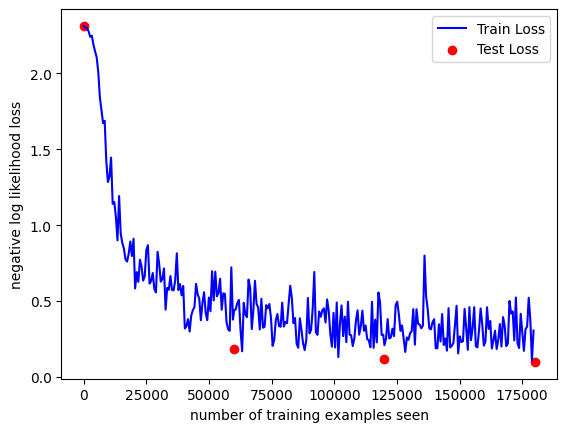

<Figure size 640x480 with 0 Axes>

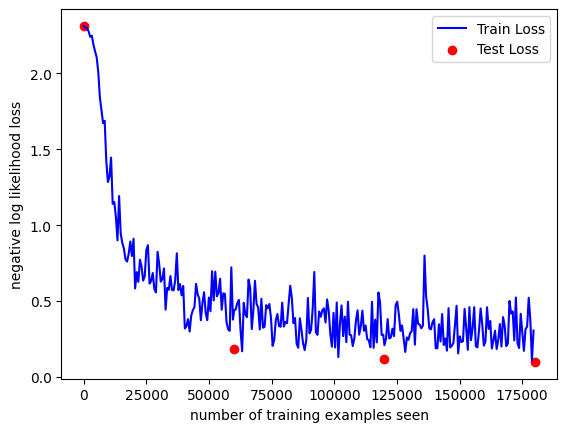

In [14]:
plt.figure().clear()
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')
fig

Check predictions for sample data

In [15]:
with torch.no_grad():
  output = network(example_data)

/tmp/ipykernel_9278/1927195578.py:37: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


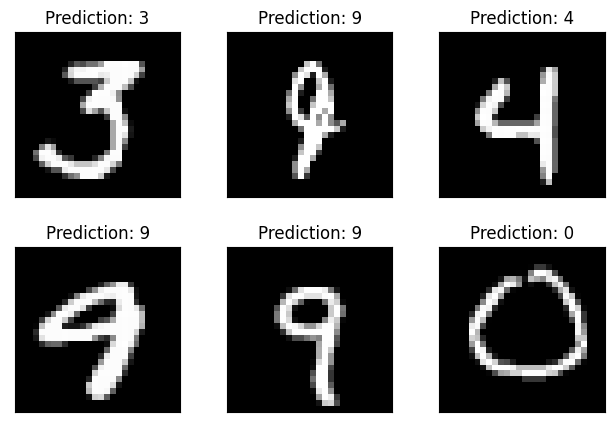

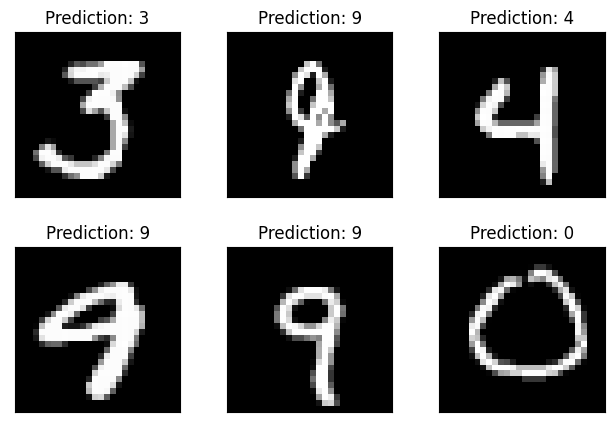

In [16]:
fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Prediction: {}".format(
    output.data.max(1, keepdim=True)[1][i].item()))
  plt.xticks([])
  plt.yticks([])
fig